In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as pl

with h5py.File('./Assignment_Data_set/train_128.h5', 'r') as H:
    X= np.copy(H['data'])
    X_train = X[0: 48000]
    X_val = X[48000: 58000]
    X_test_0 = X[58000:]
with h5py.File('./Assignment_Data_set/train_label.h5', 'r') as H:
    y = np.copy(H['label'])
    y_train = y[0: 48000]
    y_val = y[48000: 58000]
    y_test_0 = y[58000:]
with h5py.File('./Assignment_Data_set/test_128.h5', 'r') as H:
    X_test = np.copy(H['data'])

data = {}
data['X_train'] = X_train
data['X_val'] = X_val
data['X_test_0'] = X_test_0
data['y_train'] = y_train
data['y_val'] = y_val
data['y_test_0'] = y_test_0
data['X_test'] = X_test

/Users/dengxing/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Define the activation class

In [2]:
class Activation(object):

    @staticmethod
    def softmax_loss(X, y):
        """
        Parameters:
            X := softmax output
            y := desired output
        """
        
        probs = np.exp(X - np.max(X, axis=1, keepdims=True))
        probs /= np.sum(probs, axis=1, keepdims=True)
        
        # The number of training data
        N = X.shape[0]
        loss = -np.sum(y * np.log(probs[np.arange(N), y])) / N
        
        # delta
        dx = probs.copy()
        dx[np.arange(N), y] -= 1
        
        # average the delta
        dx /= N
        return loss, dx
    
    @staticmethod
    def forward(x, w, b):
        """
        Compute the forward pass for a fully-connected layer.
        Inputs:
            x := A np array containing input data of shape(N, n_in)
            w := A np array of weights, of shape (n_in, n_out)
            b := A np array of biases, of shape (M,)
            
        Returns:
            out := output of shape (N, n_out)
            cache := (x, w, b)
        """
        
        out = None
        N = x.shape[0]
        
        # if the output is not complete, padding 0
        x_rsp = x.reshape(N, -1)
        
        # output
        out = x_rsp.dot(w) + b
        cache = (x, w, b)
        return out, cache
    
    @staticmethod
    def backward(dout, cache):
        """
        Compute the backward pass for a fully-connected layer.
        Inputs:
            dout := the derivative of the output
            cache := Tuple of
                (x := input
                 w := weights)
        Returns a tutple of:
            dx := gradient w.r.t x
            dw := gradient w.r.t w
            db := gradient w.r.t b
        """
        
        x, w, b = cache
        dx, dw, db = None, None, None
        
        # The number of training data
        N = x.shape[0]
        x_rsp = x.reshape(N, -1)
        
        dx = dout.dot(w.T).reshape(*x.shape)
        dw = x_rsp.T.dot(dout)
        db = np.sum(dout, axis=0)
        return dx, dw, db
    
    @staticmethod
    def relu_forward(x):
        out = None
        out = x * (x >= 0)
        cache = x
        return out, cache
    
    @staticmethod
    def relu_backward(dout, cache):
        """
        Input:
            dout := the derivative of the output
            cache := input x, of same shape as dout
        Returns:
            dx := gradient w.r.t x
        """
        dx, x = None, cache
        dx = (x>=0) * dout
        return dx
    
    @staticmethod
    def bn_forward(x, gamma, beta, bn_param):
        """
        Inputs:
            x := data of shape (N, D)
            gamma := scale param of shape (D,)
            beta := shift param of shape (D,)
            bn_param := dict with the following keys:
                mode := 'train' or 'test'; required
                eps := Constant for numeric stability
                momentum := Constant for running mean/variance
                running_mean: Array of shape (D,) giving running mean of features
            running_var Array of shape (D,) giving running variance of features
        Returns a tuple of:
            out: of shape (N, D)
            cache: A tuple of values needed in the backward pass
        """
        mode = bn_param['mode']
        eps = bn_param.get('eps', 1e-5)
        momentum = bn_param.get('momentum', 0.9)
        
        N, D = x.shape
        running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
        running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))
        
        out, cache = None, None
        if mode == 'train':
            sample_mean = np.mean(x, axis=0)
            sample_var = np.var(x, axis=0)
            
            x_hat = (x-sample_mean) / (np.sqrt(sample_var + eps))
            out = gamma * x_hat + beta
            
            cache = (gamma, x, sample_mean, sample_var, eps, x_hat)
            
            """
            during testing, we need to recover the property
            so we have to store the running mean and var.
            Using momentum is because we want to add some randomlization
            to avoid overfitting.
            """
            running_mean = momentum * running_mean + (1-momentum) * sample_mean
            running_var = momentum * running_var + (1-momentum) * sample_var
        elif mode == 'test':
            scale = gamma / (np.sqrt(running_var + eps))
            out = x * scale + (beta - running_mean * scale)
            
        bn_param['running_mean'] = running_mean
        bn_param['running_var'] = running_var
        
        return out, cache
    
    @staticmethod
    def bn_backward(dout, cache):
        """
        Inputs:
            dout := derivatives of upstream
            cache := variables of intermediates from bn_forward
            
        Returns a tuple of:
            dx := gradient w.r.t input x
            dgamma := gradient w.r.t scale param gamme
            dbeta := gradient w.r.t shift parameter beta.
        """
        dx, dgamma, dbeta = None, None, None
        gamma, x, sample_mean, sample_var, eps, x_hat = cache
        
        # The numebr of training data
        N = x.shape[0]
        
        # derivatives
        dx_hat = dout*gamma
        dvar = np.sum(dx_hat * (x-sample_mean) * -0.5 * np.power(sample_var + eps, -1.5), axis = 0)
        dmean = np.sum(dx_hat * -1.0 / np.sqrt(sample_var + eps), axis = 0) + dvar * np.mean(-1 * (x-sample_mean), axis = 0)
        dx = 1/np.sqrt(sample_var + eps) * dx_hat + dvar * 2.0 / N * (x-sample_mean) + 1.0 / N * dmean
        dgamma = np.sum(x_hat * dout, axis = 0)
        dbeta = np.sum(dout, axis = 0)
        
        return dx, dgamma, dbeta
    
    @staticmethod
    def dropout_forward(x, dropout_param):
        """
        Inputs:
            x := input data (activated), of any shape
            dropout_param := a dict with the following keys:
                p := dropout parameter. We drop each neuron output with probability p.
                mode := 'test' or 'train'.
                seed := Seed for the random number generator.
            Outputs:
                out := array of the same shape as x.
                cache := A tuple (dropout_param, mask)
        """
        p, mode = dropout_param['p'], dropout_param['mode']
        if 'seed' in dropout_param:
            np.random.seed(dropout_param['seed'])
        
        mask = None
        out = None
        
        if mode == 'train':
            
            # Inverted dropout
            mask = (np.random.rand(*x.shape) >= p) / (1-p)
            out = x * mask
        
        elif mode == 'test':
            out = x
        
        cache = (dropout_param, mask)
        out = out.astype(x.dtype, copy = False)
        
        return out, cache
    
    
    @staticmethod
    def dropout_backward(dout, cache):
        """
        Inputs:
            dout := upstream derivatives, of any shape
            cache := (dropout_param, mask) from dropout_forward.
        """
        dropout_param, mask = cache
        mode = dropout_param['mode']
        dx = None
        
        if mode == 'train':
            dx = dout * mask
        elif mode == 'test':
            dx = dout
            
        return dx
    
    """
    ======
    The following code assembles the function above.
    General structure:
    Net values -> activation layer
    ======
    """
    
    @staticmethod
    def nn_relu_forward(x, w, b):
        """
        Layer followed by a ReLU
        
        Inputs:
            x := Input to the layer
            w, b := Weights for the layer
        
        Returns:
            out := output from the ReLU
            cache := Object to give to the backward pass
        """
        a, fc_cache = Activation.forward(x,w,b)
        out, relu_cache = Activation.relu_forward(a)
        cache = (fc_cache, relu_cache)
        
        return out, cache
    
    @staticmethod
    def nn_relu_backward(dout, cache):
        """
        Backward pass for the nn layer with ReLU
        """
        fc_cache, relu_cache = cache
        
        # dout / da, where a = net
        # da := derivative w.r.t the ReLU layer
        da = Activation.relu_backward(dout, relu_cache)
        
        # derivatives w.r.t the weight, x, b
        dx, dw, db = Activation.backward(da, fc_cache)
        
        return dx, dw, db
    
    @staticmethod
    def nn_bn_relu_forward(x, w, b, gamma, beta, bn_param):
        """
        The batch normalized version of Relu, here is the structure
        BN -> Net values -> ReLU -> output
        """
        
        """
        a := the net values of WX
        fc_cache := a cache of the x, w, and b for further process.
        """
        a, fc_cache = Activation.forward(x, w, b)
        bn, bn_cache = Activation.bn_forward(a, gamma, beta, bn_param)
        out, relu_cache = Activation.relu_forward(bn)
        cache = (fc_cache, bn_cache, relu_cache)
        
        return out, cache
    
    @staticmethod
    def nn_bn_relu_backward(dout, cache):
        """
        Backward pass for the bn nn layer with ReLU
        Returns:
            dx := derivative w.r.t input x
            dw := derivative w.r.t weight
            db := derivative w.r.t biases
            dgamma := derivative w.r.t bn param gamma
            dbeta := derivative w.r.t bn param beta
        """
        fc_cache, bn_cache, relu_cache = cache
        
        # dout / dbn
        dbn = Activation.relu_backward(dout, relu_cache)
        da, dgamma, dbeta = Activation.bn_backward(dbn, bn_cache)
        dx, dw, db = Activation.backward(da, fc_cache)
        
        return dx, dw, db, dgamma, dbeta

# Fully Connected Network
Multi-layer neural network with the following architecture:  
{Net - {BN} - ReLU - {dropout}} x (L-1) - Net - SoftMax_with_weight_decay

In [3]:
class Model(object):
    
    def __init__(self, hidden_dims, 
               input_dim = 128, 
               num_classes = 10,
               dropout = 0, 
               use_bn = True,
               reg = 0.0,
               dtype = np.float32,
               seed = None):
        """
        Inputs:
            hidden_dims := an array, the i-th value indicates the # of neurals on the i-th layer
            input_dim := the # of attributes an input has
            num_classes := target classes
            dropout := the probability of dropout
            use_bn := the model uses batch_normalization or not
        """
        self.use_bn = use_bn
        self.use_dropout = dropout > 0
        self.reg =reg
        self.dtype = dtype
        self.num_layers = 1 + len(hidden_dims)
        self.params = {}
        layer_input_dim = input_dim
        
        """
        ======
        Initializing network
        ======
        """
        # Initialize the hidden layers
        for i, hd in enumerate(hidden_dims):
            # Generate weights using Xavier
            self.params['W%d' % (i+1)] = np.random.uniform(
                low = -np.sqrt(6. / (layer_input_dim + hd)),
                high = np.sqrt(6. / (layer_input_dim + hd)),
                size = (layer_input_dim, hd)
            )
            self.params['b%d' % (i+1)] = np.zeros(hd)
            
            # If use batch normalization, we need to set up gamma and beta
            # They are originally set as 1s and 0s
            if self.use_bn:
                self.params['gamma%d' % (i+1)] = np.ones(hd)
                self.params['beta%d' % (i+1)] = np.zeros(hd)
            
            # Move to next layer
            layer_input_dim = hd
            
        # Initialize the output Layers
        self.params['W%d' % (self.num_layers)] = np.random.uniform(
                low = -np.sqrt(6. / (layer_input_dim + hd)),
                high = np.sqrt(6. / (layer_input_dim + hd)),
                size = (layer_input_dim, num_classes)
            )
        self.params['b%d' % (self.num_layers)] = np.zeros(num_classes)
        
        # In cases, casting all parameters to the correct data type
        for k,v in self.params.items():
            self.params[k] = v.astype(dtype)
        
        """
        ======
        If use dropout
        ======
        """
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {'mode' : 'train', 'p' : dropout}
            if seed is not None:
                self.dropout_param['seed'] = seed
                
        """
        ======
        If use batch normalization
        ======
        """
        self.bn_params = []
        if self.use_bn:
            self.bn_params = [{'mode' : 'train'} for i in range(self.num_layers-1)]
            
    def loss(self, X, y=None):
        """
        Compute loss and gradient for the nn.
        Inputs:
            X := array of input data with shape (N, d_1, ..., d_k)
            y := array of labels with shape (N,). y[i] gives the label for the i-th input
        
        Returns:
            loss := cross-entropy loss
            gradient := gradient
        """
        
        # Cast input
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'
        
        
        # change the dropout & bn mode
        if self.use_dropout:
            self.dropout_param['mode'] = mode
        if self.use_bn:
            for bn_param in self.bn_params:
                bn_param['mode'] = mode
            
        scores = None
        
        # forward pass for the network
        layer_input = X
        ar_cache = {}
        dp_cache = {}
        
        for lay in range(self.num_layers-1):
            # BN the input
            if self.use_bn:
                # use the nn_bn_relu_forward/backward
                layer_input, ar_cache[lay] = Activation.nn_bn_relu_forward(
                    layer_input,
                    self.params['W%d' %(lay+1)],
                    self.params['b%d' %(lay+1)],
                    self.params['gamma%d' %(lay+1)],
                    self.params['beta%d' %(lay+1)],
                    self.bn_params[lay]
                )
            else:
                layer_input, ar_cache[lay] = Activation.relu_forward(lay, self.params['W%d' %(lay+1), self.params['b%d' %(lay+1)]])
        
            if self.use_dropout:
                layer_input, dp_cache[lay] = Activation.dropout_forward(layer_input, self.dropout_param)

        ar_out, ar_cache[self.num_layers] = Activation.forward(layer_input, self.params['W%d'%(self.num_layers)], self.params['b%d'%(self.num_layers)])
        scores = ar_out
        
        """
        Return the raw prediction
        The model is not responsible for outputing the exactly correct output but the row values
        i.e.:
            [0.8327949832,12312312,4543,0.5454]
        instead of
            [0, 1, 0, 0] (i.e. the prediction says the input belongs to class 2)
        
        The solver takes the job
        """
        if mode == 'test':
            return scores
        
        loss, grads = 0.0, {}
        
        """
        ======
        The following code block calculates the softmax loss and gradients
        using weight decay, it add L2 regularization to loss function
        ======
        """
        loss, dscores = Activation.softmax_loss(scores, y)
        dhout = dscores
        
        # Weight decay
        loss = loss + 0.5 * self.reg * np.sum(self.params['W%d'%(self.num_layers)] * self.params['W%d'%(self.num_layers)])
        dx, dw, db = Activation.backward(dhout, ar_cache[self.num_layers])
        
        # Gradient
        grads['W%d' %(self.num_layers)] = dw + self.reg * self.params['W%d' % (self.num_layers)]
        grads['b%d' % (self.num_layers)] = db
        
        # Update gradient
        dhout = dx
        
        # Backpropagation
        for idx in range(self.num_layers-1):
            lay = self.num_layers - 1 - idx - 1
            loss = loss + 0.5 * self.reg * np.sum(self.params['W%d'%(lay+1)] * self.params['W%d'%(lay+1)])
            
            if self.use_dropout:
                dhout = Activation.dropout_backward(dhout, dp_cache[lay])
                
            if self.use_bn:
                dx, dw, db, dgamma, dbeta = Activation.nn_bn_relu_backward(dhout, ar_cache[lay])
            else:
                dx, dw, db = Activation.relu_backward(dhout, ar_cache[lay])
                
            grads['W%d' % (lay+1)] = dw + self.reg * self.params['W%d' %(lay+1)]
            grads['b%d' % (lay+1)] = db
            
            if self.use_bn:
                grads['gamma%d' % (lay+1)] = dgamma
                grads['beta%d' % (lay+1)] = dbeta
            dhout = dx
        return loss, grads
        

## Optimizer: SGD with Momentum
     Stochastic gradient descent with more configures.
     - momentum: Scalar between 0 and 1 giving the momentum value.
     - velocity: A numpy array of the same shape as w and dw used to store a moving average of the gradients.

In [4]:
class Optim:
    """
    Stochastic gradient descent without momentum
    Inputs:
        w := original weights
        dw := gradients
    """
    @staticmethod
    def sgd(w, dw, config = None):
        if config is None:
            config = {}
        config.setdefault('learning_rate', 1e-2)
        w -= config['learning_rate'] * dw
        return w, config
        
    @staticmethod
    def sgd_momentum(w, dw, config = None):
        if config is None:
            config = {}
        config.setdefault('learning_rate', 1e-2)
        config.setdefault('momentum', 0.9)
        
        """
        Fetching previous velocity
        if none, set to zeros
        """
        v = config.get('velocity', np.zeros_like(w))
        next_w = None
        
        """
        Computing new velocity
        """
        v = config['momentum'] * v - config['learning_rate'] * dw
        next_w = w + v
        config['velocity'] = v
        
        return next_w, config

## Solver
    A Solver encapsulates all the logic necessary for training classification  models. 
    The Solver performs stochastic gradient descent using different update rules defined in optim.py.
    The solver accepts both training and validataion data and labels so it can periodically check classification accuracy.

In [5]:
class Solver(object):
    
    """
    Inputs:
        model := the multi-layer nn model
        data := a dict, with the following keys
            X_train := training set
            y_train := labels for the training set
            X_val := validation set
            y_val = validation set's labels
    """
    def __init__(self, model, data, **kwargs):
        self.model = model
        self.X_train = data['X_train']
        self.y_train = data['y_train']
        self.X_val = data['X_val']
        self.y_val = data['y_val']
        
        # Unpack keyward args
        self.update_rule = kwargs.pop('update_rule', 'sgd')
        self.optim_config = kwargs.pop('optim_config', {})
        self.lr_decay = kwargs.pop('lr_decay', 1.0)
        self.batch_size = kwargs.pop('batch_size', 100)
        self.num_epochs = kwargs.pop('num_epochs', 10)
        
        # Print the result (loss, accuracy) every n epochs
        self.print_every = kwargs.pop('print_every', 10)
        self.verbose = kwargs.pop('verbose', True)

        # Check if the update rule exists or not
        if not hasattr(Optim, self.update_rule):
            raise ValueError('Invalid update rule "%s"' % self.update_rule)
        
        self.update_rule = getattr(Optim, self.update_rule)
        
        self._reset()
        
    """
    ======
    Reset primary parameters for further training
    Parameters:
        epoch := the number of current epoch
        best_val_acc := the best accuracy of our model for validation set
        best_params := the best weights, biases, gamma and beta(if has)
        loss_history := for printing training history
    ======
    """
    def _reset(self):
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        
        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k : v for k,v in self.optim_config.items()}
            self.optim_configs[p] = d
            
    """
    ======
    Update the gradient of every parameters
    Utilize minibatch
    ======
    """
    def _step(self):
        
        # Making
        num_train = self.X_train.shape[0]
        # Randomly choose the training data
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]
        
        # Compute loss and grad
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)
        
        # Updat nn's parameter
        for p, w in self.model.params.items():
            # p := the keyof parameters in the nn, could be weights, biases, gamma or beta
            # w is similar, can not only be weight but biases, gamma or beta, velocity etc.
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config
        
    def check_accuracy(self, X, y, num_samples = None, batch_size = 100):
        # The number of training data
        N = X.shape[0]
        
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]
        
        # Compute prediction in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i+1) * batch_size
            scores = self.model.loss(X[start:end])
            # get the prediction
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)
        
        return acc
    
    """
    ======
    Train the model
    ======
    """
    def train(self):
        num_train = self.X_train.shape[0]
        
        # How many batches are run in each epoch
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        
        # Total number of batches
        num_iterations = self.num_epochs * iterations_per_epoch
        
        for t in range(num_iterations):
            # Tran the nn using only one batch
            self._step()
            
            # Print the result after one epoch
            if t % self.print_every == 0:
                print('(Iteration %d / %d) loss: %f' % (t+1, num_iterations, self.loss_history[-1]))
                
            # At the end of every epoch, increment the epoch counter and decay the learning rate
            epoch_end = (t+1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]['learning_rate'] *= self.lr_decay
                    
            first_it = (t == 0)
            last_it = (t == num_iterations + 1)
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(self.X_train, self.y_train, num_samples = 1000)
                val_acc = self.check_accuracy(self.X_val, self.y_val)
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                
                print('(Epoch %d / %d) train acc: %f; val_acc: %f' % (self.epoch, self.num_epochs, train_acc, val_acc))
                
                # Similar to the early stop, but keep training until the end
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    # Deep copy the params
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()
            # At the end of training, only keep the best params
            self.model.params = self.best_params
            
        """
        Predict the inputs X
        Inputs:
            X := a matrix of shape (N, d_1, ..., d_k), where N := the number of inputs, and k := the number of attributes
        Returns:
            y_pred := the prediction arrary of shape (N,), where the i-th entry is the prediction of the i-th input.
        """
        def predict(self, X):
            y_pred = []
            
            # the raw prediction
            scores = self.model.loss(X)
            
            # appending the prediction
            y_pred.append(np.argmax(scores, axis=1))
            
            # make the predictions be horizontal
            y_pred = np.hstack(y_pred)
            return y_pred

## Implementation
    Train the best fully-connected model with the giving dataset, storing your best model in the best_model variable. And then compute the  validating and test accuracy. 

In [6]:
import time
import matplotlib.pyplot as plt

best_model = None

learning_rate = 1e-2

model = Model([600, 500, 400, 300, 200, 100], dtype = np.float64, dropout = 0.25, use_bn = True, reg = 1e-2)
solver = Solver(model, data, print_every=500, num_epochs = 50, batch_size = 100,
               update_rule = 'sgd_momentum',
               optim_config = {
                   'learning_rate' : learning_rate,
               },
               lr_decay = 0.9)

solver.train()
scores = model.loss(data['X_test_0'])
y_pred = np.argmax(scores, axis = 1)
acc = np.mean(y_pred == data['y_test_0'])
print ('test acc: %f' %(acc))

(Iteration 1 / 24000) loss: 22.764764
(Epoch 0 / 50) train acc: 0.100000; val_acc: 0.103900
(Epoch 1 / 50) train acc: 0.825000; val_acc: 0.836100
(Iteration 501 / 24000) loss: 5.546189
(Epoch 2 / 50) train acc: 0.855000; val_acc: 0.856300
(Iteration 1001 / 24000) loss: 3.722274
(Epoch 3 / 50) train acc: 0.868000; val_acc: 0.857900
(Iteration 1501 / 24000) loss: 2.097455
(Epoch 4 / 50) train acc: 0.861000; val_acc: 0.868100
(Iteration 2001 / 24000) loss: 1.652761
(Epoch 5 / 50) train acc: 0.865000; val_acc: 0.846900
(Iteration 2501 / 24000) loss: 1.823375
(Epoch 6 / 50) train acc: 0.891000; val_acc: 0.867600
(Iteration 3001 / 24000) loss: 1.749654
(Epoch 7 / 50) train acc: 0.896000; val_acc: 0.870100
(Iteration 3501 / 24000) loss: 1.576010
(Epoch 8 / 50) train acc: 0.894000; val_acc: 0.863900
(Iteration 4001 / 24000) loss: 1.906359
(Epoch 9 / 50) train acc: 0.873000; val_acc: 0.865500
(Iteration 4501 / 24000) loss: 1.824426
(Epoch 10 / 50) train acc: 0.872000; val_acc: 0.869600
(Iterati

Plot the acc and loss

Validation set accuracy:  0.906
Test set accuracy:  0.9055


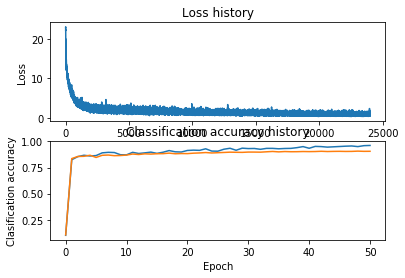

In [7]:
best_model = model
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print ('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
# print(y_val_pred == data['y_val'])

y_test_pred = np.argmax(best_model.loss(data['X_test_0']), axis=1)
# print(y_test_pred)
# print(data['y_test_0'])
print ('Test set accuracy: ', (y_test_pred == data['y_test_0']).mean())


plt.subplot(2, 1, 1)
plt.plot(solver.loss_history)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, label='train')
plt.plot(solver.val_acc_history, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [8]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
with h5py.File('Predicted_labels.h5', 'w') as H:
    H.create_dataset('label', data=y_test_pred)